In [96]:
# Step 0: Machine Learning Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Models for Comparison
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- Configuration ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

In [97]:
# --- Step 1: Data Loading and Initial Cleaning ---
print("--- Step 1: Loading and Initial Data Cleaning ---")
try:
    df = pd.read_csv('networktraffic.csv', delimiter='|', on_bad_lines='skip')
    print(f"✅ Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    print(f" Data preview: {df.head}")
except Exception as e:
    print(f"❌ Error loading CSV file: {e}")
    exit()

# Replace placeholder '-' with actual NaN for proper analysis
df.replace('-', np.nan, inplace=True)
print("✅ Replaced placeholder '-' with NaN.")

--- Step 1: Loading and Initial Data Cleaning ---
✅ Dataset loaded successfully with 10403 rows and 23 columns.
 Data preview: <bound method NDFrame.head of                  ts                 uid        id.orig_h  id.orig_p  \
0      1.533043e+09   C5JLGOoxIw2dBZt47  192.168.100.113        123   
1      1.533043e+09  Cf3cHf4jZr9nvD808i  192.168.100.113        123   
2      1.533043e+09  CJgmSt3bSY6XwE9fzc  192.168.100.113        123   
3      1.533043e+09  Cav32m4csR3OZYhShj  192.168.100.113        123   
4      1.533043e+09  ClwPfA40tU9UT4nksg  192.168.100.113        123   
...             ...                 ...              ...        ...   
10398  1.533129e+09  CnFPqm2V3khhpDHVph  192.168.100.113      47432   
10399  1.533129e+09  C76idj4jtLwpz9S3L7  192.168.100.113      38252   
10400  1.533129e+09   CkMeQi2atLqx0NfAR  192.168.100.113      38252   
10401  1.533129e+09  CypjCo4WicqE74GkUl  192.168.100.113        123   
10402  1.533129e+09  CC4Tss16O1KtMckgZj  192.168.100.113      

In [98]:
# --- Step 1.5: Data Examining and basic transformation ---
print(df.dtypes)

ts                float64
uid                object
id.orig_h          object
id.orig_p           int64
id.resp_h          object
id.resp_p           int64
proto              object
service           float64
duration           object
orig_bytes         object
resp_bytes         object
conn_state         object
local_orig        float64
local_resp        float64
missed_bytes        int64
history            object
orig_pkts           int64
orig_ip_bytes       int64
resp_pkts           int64
resp_ip_bytes       int64
tunnel_parents    float64
label              object
detailed-label     object
dtype: object



--- Step 2: Exploratory Data Analysis (EDA) ---

🔍 Analyzing missing values...
                count     percent
local_resp      10403  100.000000
local_orig      10403  100.000000
service         10403  100.000000
tunnel_parents  10403  100.000000
duration         6185   59.454004
orig_bytes       6185   59.454004
resp_bytes       6185   59.454004
detailed-label   2181   20.965106
proto               0    0.000000
id.resp_h           0    0.000000
id.resp_p           0    0.000000
id.orig_h           0    0.000000
uid                 0    0.000000
ts                  0    0.000000
id.orig_p           0    0.000000
missed_bytes        0    0.000000
conn_state          0    0.000000
history             0    0.000000
orig_pkts           0    0.000000
resp_pkts           0    0.000000
orig_ip_bytes       0    0.000000
resp_ip_bytes       0    0.000000
label               0    0.000000

Justification: Dropping columns with >50% missing values: ['service', 'duration', 'orig_bytes', 'resp_b

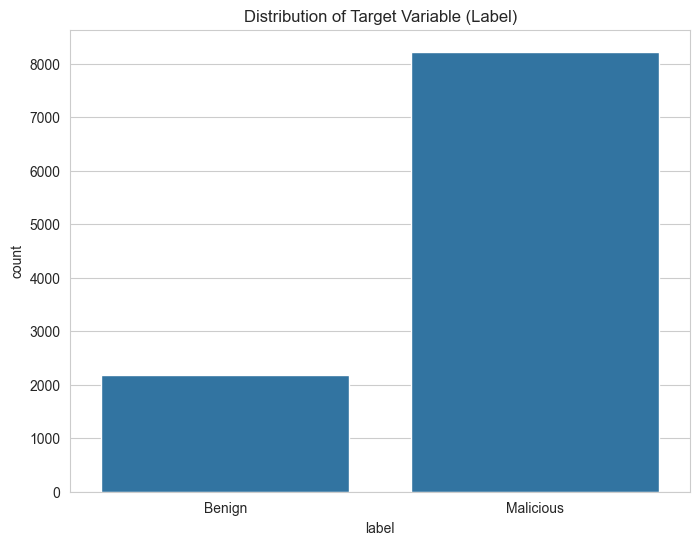

Justification: Target class is imbalanced. SMOTE will be used to address this.


In [99]:
# --- Step 2: Exploratory Data Analysis (EDA) & Justified Feature Elimination ---
print("\n--- Step 2: Exploratory Data Analysis (EDA) ---")

# 2a: Missing Value Analysis
print("\n🔍 Analyzing missing values...")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'count': missing_values, 'percent': missing_percent})
print(missing_df.sort_values(by='percent', ascending=False))

# Justification for dropping columns with high nulls
cols_to_drop_nulls = missing_df[missing_df['percent'] > 50].index.tolist()
if cols_to_drop_nulls:
    print(f"\nJustification: Dropping columns with >50% missing values: {cols_to_drop_nulls}")
    df.drop(columns=cols_to_drop_nulls, inplace=True)

# 2b: Identifier and High Cardinality Analysis
print("\n🔍 Analyzing high cardinality and identifier columns...")
# Keep id.orig_h, id.resp_h, and ts as requested. Drop only uid.
identifier_cols = ['uid']
print(f"Justification: Dropping identifier columns: {identifier_cols}")
df.drop(columns=identifier_cols, inplace=True)

# 2c: Redundant Label Analysis
# Keep ts, drop only detailed-label
other_cols_to_drop = ['detailed-label']
print(f"Justification: Dropping redundant label ('detailed-label'). Keeping 'ts' for feature engineering.")
df.drop(columns=other_cols_to_drop, inplace=True)

# 2d: Statistical Description of Numerical Data
print("\n📊 Statistical Summary of Numerical Columns:")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='ignore')
print(df.describe())

# 2e: Target Variable Distribution
print("\n📊 Visualizing Target Class Distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Target Variable (Label)')
plt.show()
is_imbalanced = df['label'].value_counts(normalize=True).min() < 0.4
if is_imbalanced:
    print("Justification: Target class is imbalanced. SMOTE will be used to address this.")



--- Step 3: Final Preprocessing ---
✅ Imputed all remaining missing values.
✅ Converted IPs to integer representation.
✅ Encoded categorical features and target label.
✅ Removed duplicate rows.

📊 Visualizing Feature Correlation with Target...


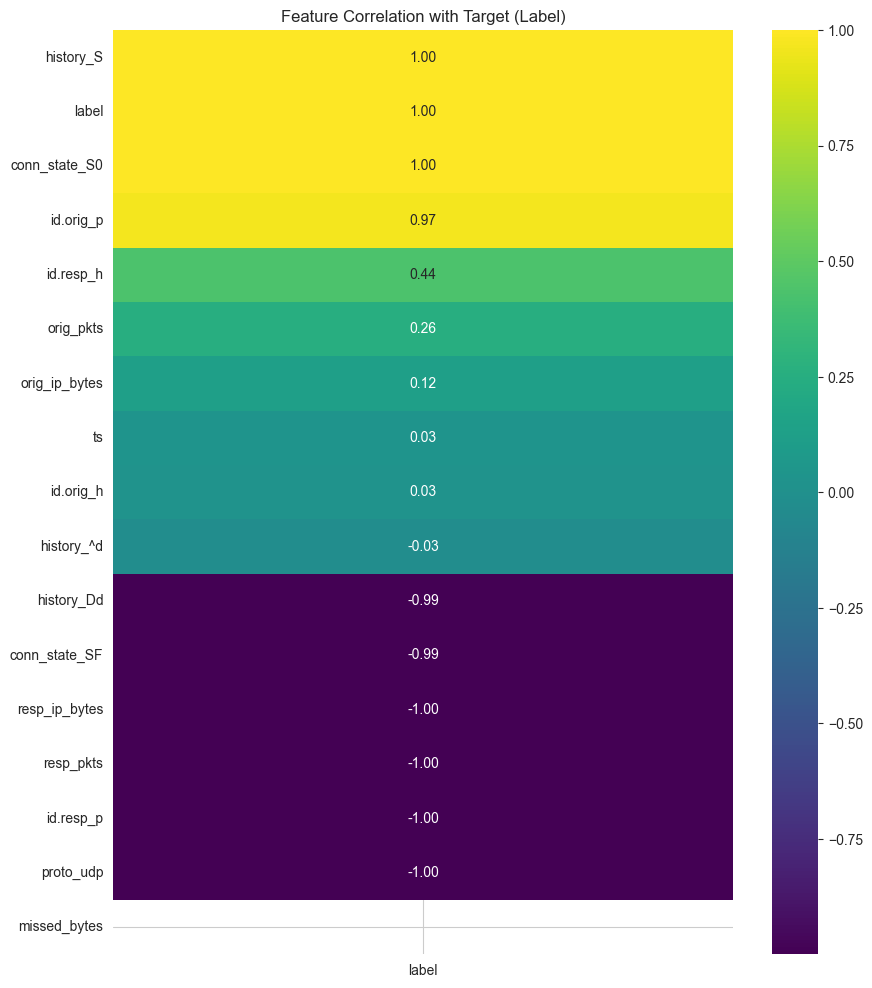

In [100]:
# --- Step 3: Final Preprocessing and Feature Engineering ---
print("\n--- Step 3: Final Preprocessing ---")

# Impute missing values
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != 'label':
        df[col].fillna(df[col].mode()[0], inplace=True)

df.dropna(subset=['label'], inplace=True)
print("✅ Imputed all remaining missing values.")

# Convert IPs to integers instead of one-hot encoding
import ipaddress
def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except:
        return None

if 'id.orig_h' in df.columns:
    df['id.orig_h'] = df['id.orig_h'].apply(ip_to_int)
if 'id.resp_h' in df.columns:
    df['id.resp_h'] = df['id.resp_h'].apply(ip_to_int)

print("✅ Converted IPs to integer representation.")

# Encode categorical features (excluding IPs and numeric cols)
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('label')

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_encoded['label'] = label_encoder.fit_transform(df_encoded['label'])
print("✅ Encoded categorical features and target label.")

# Drop duplicates
df_encoded.drop_duplicates(inplace=True)
print("✅ Removed duplicate rows.")

# Correlation Heatmap (after encoding)
print("\n📊 Visualizing Feature Correlation with Target...")
plt.figure(figsize=(10, 12))
corr_matrix = df_encoded.corr()
target_corr = corr_matrix[['label']].sort_values(by='label', ascending=False)
sns.heatmap(target_corr, annot=True, cmap='viridis', fmt=".2f")
plt.title('Feature Correlation with Target (Label)')
plt.show()

In [101]:
# --- Step 3.5: Handling Data Leakage by removing high-correlation leakage dummies ---
corr_threshold = 0.95
high_corr_cols = [col for col in df_encoded.columns 
                  if col != 'label' and abs(df_encoded[col].corr(df_encoded['label'])) > corr_threshold]

if high_corr_cols:
    print(f"⚠️ Dropping high-correlation columns with label: {high_corr_cols}")
    df_encoded.drop(columns=high_corr_cols, inplace=True)
else:
    print("✅ No high-correlation leakage columns found.")

print(df_encoded.columns)

⚠️ Dropping high-correlation columns with label: ['id.orig_p', 'id.resp_p', 'resp_pkts', 'resp_ip_bytes', 'proto_udp', 'conn_state_S0', 'conn_state_SF', 'history_Dd', 'history_S']
Index(['ts', 'id.orig_h', 'id.resp_h', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes', 'label', 'history_^d'],
      dtype='object')


c:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Python312\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [102]:
# --- Step 4: Model Training and Handling Class Imbalance ---
print("\n--- Step 4: Splitting Data and Applying SMOTE ---")
X = df_encoded.drop('label', axis=1)
y = df_encoded['label']

# Split data BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

if is_imbalanced:
    print("Applying SMOTE to the training data...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("✅ SMOTE applied. Training set is now balanced.")



--- Step 4: Splitting Data and Applying SMOTE ---
Applying SMOTE to the training data...
✅ SMOTE applied. Training set is now balanced.


In [103]:
# --- Step 4.5: Leakage Diagnostic ---
print("\n--- Step 3.6: Leakage Diagnostic ---")

from sklearn.metrics import accuracy_score

leaky_features = []
for col in X.columns:
    # Simple rule: predict label 1 if test value was seen in training positives
    preds = (X_test[col].isin(X_train[y_train==1][col])).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > 0.95:  # suspiciously high accuracy
        print(f"⚠️ Column '{col}' alone predicts label with {acc:.2f} accuracy")
        leaky_features.append(col)

if leaky_features:
    print(f"\n⚠️ Dropping leaky features: {leaky_features}")
    X_train = X_train.drop(columns=leaky_features)
    X_test = X_test.drop(columns=leaky_features)
else:
    print("✅ No strong leakage detected.")



--- Step 3.6: Leakage Diagnostic ---
⚠️ Column 'id.resp_h' alone predicts label with 1.00 accuracy
⚠️ Column 'orig_ip_bytes' alone predicts label with 1.00 accuracy

⚠️ Dropping leaky features: ['id.resp_h', 'orig_ip_bytes']


In [104]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✅ Standard scaling applied. Data is now uniform.")

✅ Standard scaling applied. Data is now uniform.



--- Step 5: Training and Evaluating Unsupervised Model ---

========== Training Isolation Forest ==========
Isolation Forest Accuracy: 0.5935

Classification Report for Isolation Forest:
              precision    recall  f1-score   support

      Benign       0.27      0.57      0.37       436
   Malicious       0.84      0.60      0.70      1645

    accuracy                           0.59      2081
   macro avg       0.56      0.59      0.54      2081
weighted avg       0.72      0.59      0.63      2081



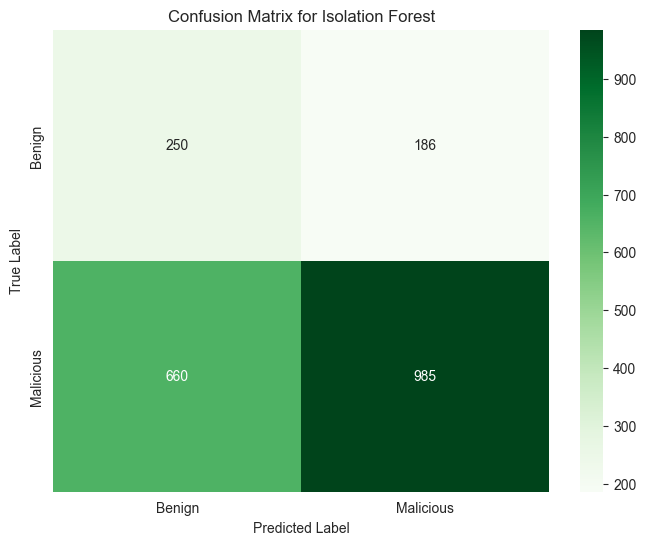

In [105]:
# --- Step 5: Unsupervised Anomaly Detection (Isolation Forest) ---
print("\n--- Step 5: Training and Evaluating Unsupervised Model ---")

# Calculate contamination based on the proportion of malicious traffic in the training set
contamination_rate = y_train.value_counts(normalize=True)[1]

print(f"\n{'='*10} Training Isolation Forest {'='*10}")
iso_forest = IsolationForest(contamination=contamination_rate, random_state=42)
iso_forest.fit(X_train)

# Predict on the test set. Model returns 1 for inliers and -1 for outliers.
y_pred_iso_raw = iso_forest.predict(X_test)

# Map predictions to our label encoding (0: Benign, 1: Malicious)
# Assumption: Outliers (-1) are Malicious (1), and Inliers (1) are Benign (0).
y_pred_iso = np.where(y_pred_iso_raw == -1, 1, 0)
iso_accuracy = accuracy_score(y_test, y_pred_iso)
print(f"Isolation Forest Accuracy: {iso_accuracy:.4f}")

# Store results for final comparison
results = {"Isolation Forest": iso_accuracy}

# Classification Report
print("\nClassification Report for Isolation Forest:")
print(classification_report(y_test, y_pred_iso, target_names=label_encoder.classes_))

# Confusion Matrix
cm_iso = confusion_matrix(y_test, y_pred_iso)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


--- Step 6: Training and Evaluating Multiple Models ---

========== Training Logistic Regression ==========

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Benign       0.26      1.00      0.41       436
   Malicious       1.00      0.25      0.39      1645

    accuracy                           0.40      2081
   macro avg       0.63      0.62      0.40      2081
weighted avg       0.84      0.40      0.40      2081



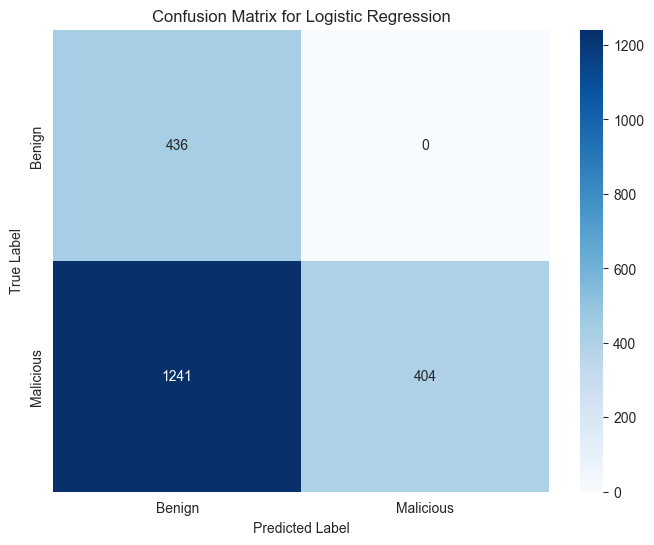


========== Training Naive Bayes ==========

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

      Benign       0.26      1.00      0.41       436
   Malicious       1.00      0.25      0.39      1645

    accuracy                           0.40      2081
   macro avg       0.63      0.62      0.40      2081
weighted avg       0.84      0.40      0.40      2081



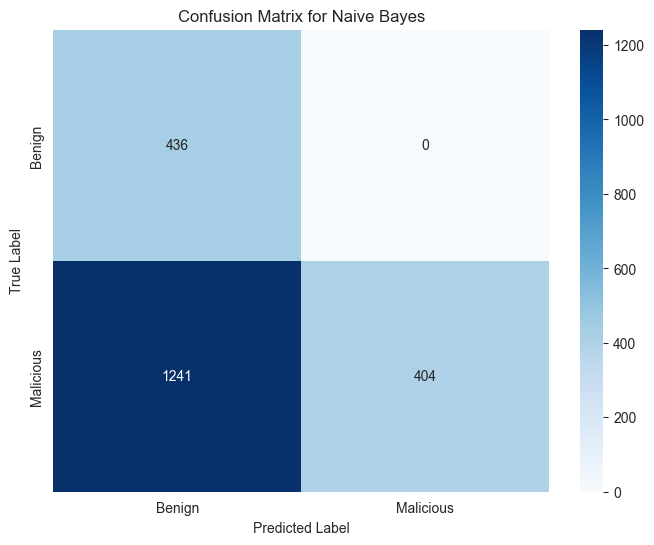


========== Training Linear SVM ==========

Classification Report for Linear SVM:
              precision    recall  f1-score   support

      Benign       0.26      1.00      0.41       436
   Malicious       1.00      0.25      0.39      1645

    accuracy                           0.40      2081
   macro avg       0.63      0.62      0.40      2081
weighted avg       0.84      0.40      0.40      2081



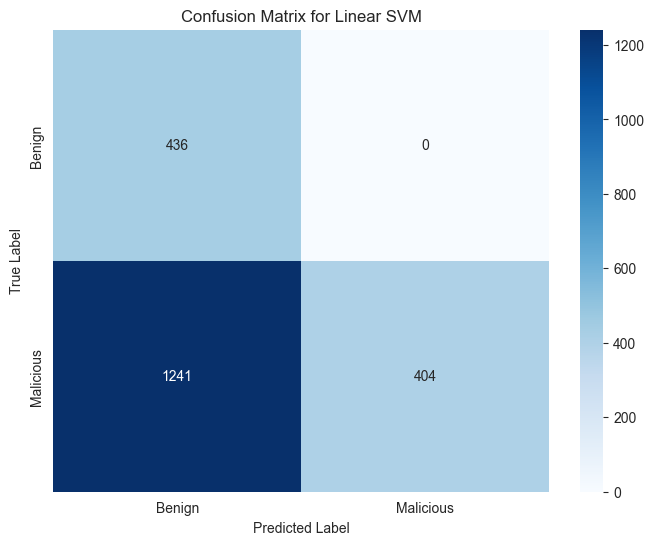


========== Training Neural Network ==========

Classification Report for Neural Network:
              precision    recall  f1-score   support

      Benign       0.26      0.96      0.41       436
   Malicious       0.96      0.28      0.43      1645

    accuracy                           0.42      2081
   macro avg       0.61      0.62      0.42      2081
weighted avg       0.81      0.42      0.43      2081



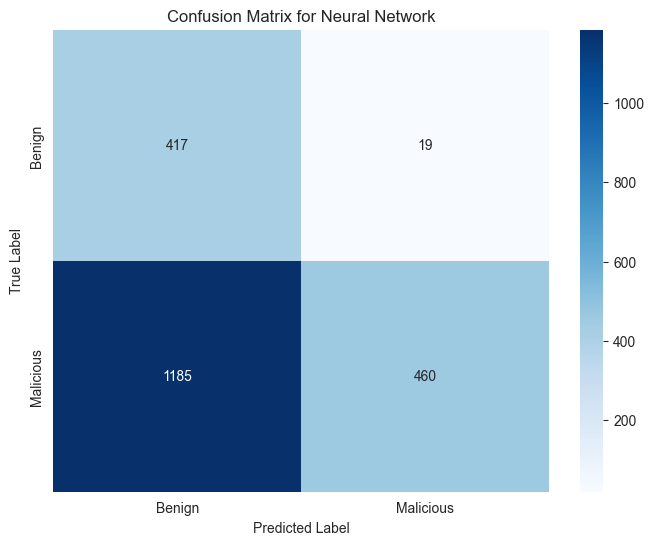


========== Training Random Forest ==========

Classification Report for Random Forest:
              precision    recall  f1-score   support

      Benign       0.21      0.50      0.30       436
   Malicious       0.79      0.50      0.62      1645

    accuracy                           0.50      2081
   macro avg       0.50      0.50      0.46      2081
weighted avg       0.67      0.50      0.55      2081



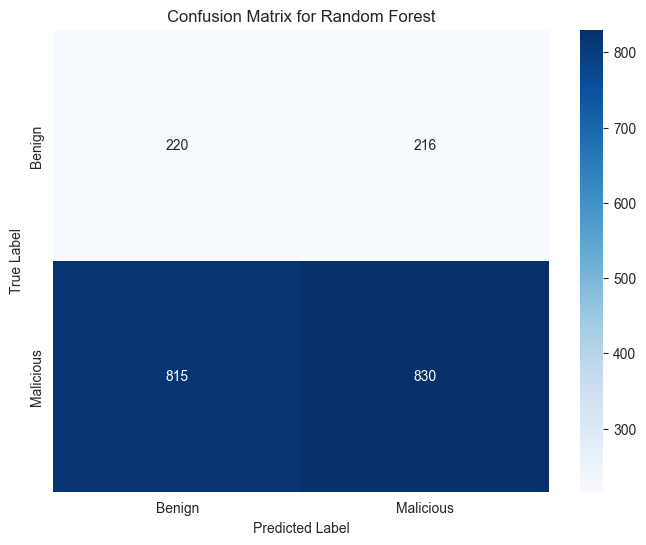


========== Training KNN (k=7) ==========

Classification Report for KNN (k=7):
              precision    recall  f1-score   support

      Benign       0.16      0.42      0.23       436
   Malicious       0.73      0.42      0.53      1645

    accuracy                           0.42      2081
   macro avg       0.44      0.42      0.38      2081
weighted avg       0.61      0.42      0.47      2081



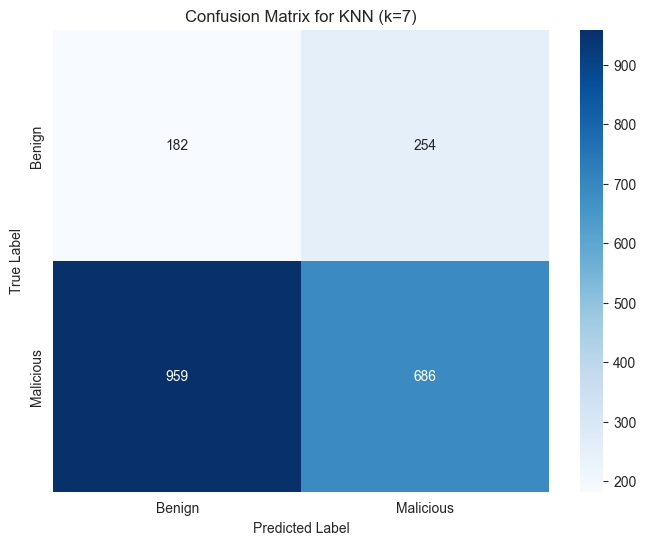

In [106]:
# --- Step 6: Train and Compare Multiple Models ---
print("\n--- Step 6: Training and Evaluating Multiple Models ---")

models = {
    "Logistic Regression": (LogisticRegression(max_iter=2000, random_state=42, C=5), True),
    "Naive Bayes": (GaussianNB(), False),
    "Linear SVM": (LinearSVC(random_state=42, max_iter=10000, C=0.5), True),
    "Neural Network": (MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, 
                                     early_stopping=True, random_state=42), True),
    "Random Forest": (RandomForestClassifier(n_estimators=300, max_depth=15, 
                                             min_samples_split=5, random_state=42), False),
    "KNN (k=7)": (KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski'), True)
}



results = {}
for name, (model, needs_scaling) in models.items():
    print(f"\n{'='*10} Training {name} {'='*10}")
    if needs_scaling:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # Individual Classification Report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Individual Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


--- Step 7: Final Model Comparison ---

📊 Final Accuracy Comparison:
                 Model  Accuracy
4        Random Forest  0.504565
3       Neural Network  0.421432
5            KNN (k=7)  0.417107
0  Logistic Regression  0.403652
1          Naive Bayes  0.403652
2           Linear SVM  0.403652


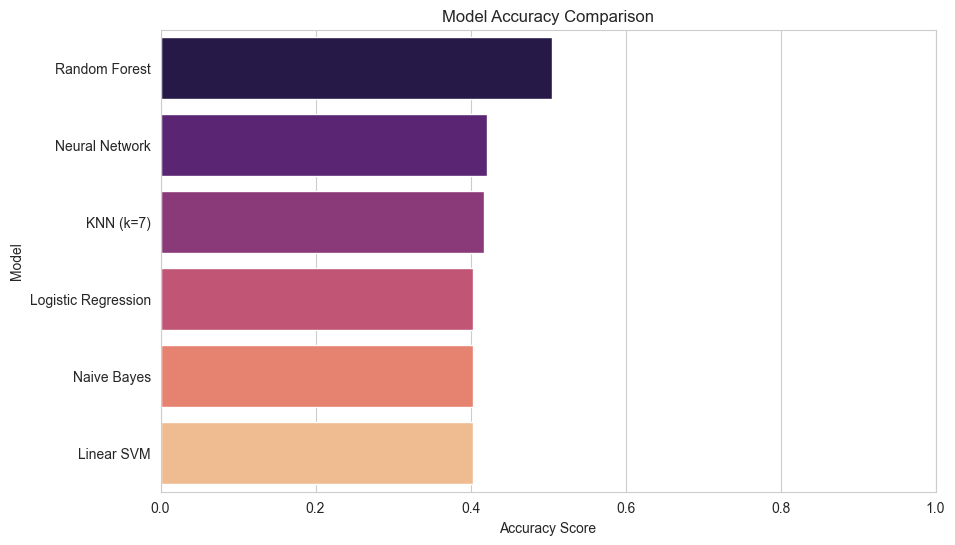


🏆 Conclusion: Based on accuracy, the best performing model is **Random Forest**.


In [107]:
# --- Step 7: Final Comparison and Conclusion ---
print("\n--- Step 7: Final Model Comparison ---")
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy']).sort_values(by='Accuracy', ascending=False)

print("\n📊 Final Accuracy Comparison:")
print(results_df)

# Visualize the comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='magma')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy Score')
plt.xlim(0.0, 1.0)
plt.show()

best_model_name = results_df.iloc[0]['Model']
print(f"\n🏆 Conclusion: Based on accuracy, the best performing model is **{best_model_name}**.")